## TabNet Implentation for Tabular Data

TabNet is proposed in [this article] (https://arxiv.org/abs/1908.07442) as a neural network architecture capable of learning a canonical representation of tabular data. This architecture has shown to perform well against the current gold-standard gradient boosting models for learning on tabular data.

TabNet uses a sequential attention mechanism to choose a subset of semantically meaningful
features to process at each decision step. Instance-wise feature selection enables efficient learning as the model capacity is fully used for the most salient features, and also yields
more interpretable decision making via visualization of selection masks. 


This implementation closely follows [the TabNet implementation in PyTorch linked here](https://github.com/dreamquark-ai/tabnet/tree/b6e1ebaf694f37ad40a6ba525aa016fd3cec15da). 

<img src="images/tabnet_schematic2.jpg" width="1000" height="800" align="center"/>


#### GLU Block

Gated Linear Units act as an attention mechanism where the gates formed involve taking two dense layer outputs, applying a sigmoid to one of them, and then multiplying them together

Following GLU blcok contains two dense layers, two ghost batch normalization layers, identity and sigmoid activation functions and multiplication operation.


### Feature Transformer Block

Builds two GLU blocks with a skip connection from the output of the first

<img src="images/tabnet_feature_transformer.jpg" width="700" height="500" align="center"/>

#### Attentive Transformer Block

Use TabNet prior as an input to layer and reserve to handle prior updates in TabNet step layer

> *prior is used to encourage orthogonal feature selection across decision steps, tell us what we know about features and how we have used them in the previous step

<img src="images/tabnet_attentive_transformer.jpg" width="200" height="200" align="center"/>

In [ ]:
# ! pip install pytorch-tabnet

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import global_variables as gv
import utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [2]:
df = pd.read_csv('data/entire_imputed.csv')
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,1319-0.0,1408-0.0,1329-0.0,1448-0.0,1538-0.0,6142-0.0,2050-0.0,1508-0.0,1339-0.0,30710-0.0,1349-0.0,30750-0.0,1468-0.0,20117-0.0,30740-0.0,1160-0.0,2090-0.0,31-0.0,1488-0.0,30850-0.0,4080-0.0,1369-0.0,21000-0.0,1200-0.0,1289-0.0,30790-0.0,845-0.0,48-0.0,30630-0.0,1299-0.0,1220-0.0,1548-0.0,1528-0.0,23099-0.0,49-0.0,30690-0.0,1389-0.0,2654-0.0,1249-0.0,1309-0.0,1379-0.0,1239-0.0,21003-0.0,30780-0.0,1438-0.0,30870-0.0,1359-0.0,30770-0.0,21001-0.0,1458-0.0,23100-0.0,6138-0.0,1418-0.0,1478-0.0,4079-0.0,30760-0.0,23101-0.0,2100-0.0,1428-0.0,30640-0.0,hypertension,outcome_cardiomyopathies,outcome_ischemic_heart_disease,outcome_heart_failure,outcome_peripheral_vascular_disease,outcome_cardiac_arrest,outcome_cerebral_infarction,outcome_arrhythmia,outcome_myocardial_infarction,CVD
0,0.0,1.0,2.0,3.0,2.0,1.0,2.0,3.0,2.0,0.34,1.0,34.937,3.0,2.0,5.622,7.0,1.0,0.0,6.00,0.508,110.0,1.0,1001.0,3.0,6.0,54.4035,20.90,74.0,1.593,10.0,0.0,2.0,2.00,35.6,102.0,6.477,1.0,6.0,1.0,2.0,1.0,0.0,54.0,3.888,10.0,0.977,2.0,26.339,24.5790,3.86,25.0,1.0,3.0,1.0,77.0,1.706,45.2,1.0,0.0,1.211,0,0,0,0,0,0,0,1,0,1
1,0.0,3.0,2.0,1.0,0.0,1.0,1.0,2.0,2.0,3.94,4.0,40.900,5.0,2.0,5.052,9.0,0.0,1.0,2.00,13.088,166.0,2.0,1001.0,2.0,2.0,15.4000,16.00,120.0,1.390,2.0,0.0,2.0,2.47,36.5,113.0,5.512,1.0,7.0,1.0,1.0,2.0,0.0,65.0,3.520,12.0,2.358,3.0,10.701,35.0861,7.00,42.9,3.0,2.0,1.0,91.0,1.173,74.6,0.0,1.0,1.019,1,0,1,0,0,0,0,0,1,0
2,0.0,3.0,3.0,2.0,1.0,2.0,1.0,2.0,2.0,0.55,1.0,40.000,1.0,0.0,5.310,5.0,0.0,0.0,0.00,0.515,132.0,1.0,1001.0,3.0,2.0,32.1000,16.00,66.0,2.005,4.0,0.0,1.0,1.00,29.5,88.0,7.079,1.0,7.0,3.0,4.0,2.0,0.0,69.0,4.227,8.0,0.655,2.0,10.693,19.3835,7.00,15.2,3.0,2.0,1.0,67.0,2.490,36.3,0.0,1.0,1.097,0,0,0,0,0,0,0,0,0,0
3,3.0,3.0,3.0,3.0,0.0,2.0,1.0,2.0,2.0,0.45,2.0,37.300,4.0,2.0,4.449,7.0,0.0,1.0,5.00,4.675,178.0,2.0,1001.0,1.0,3.0,43.5620,18.00,110.0,1.474,2.0,0.0,1.0,2.00,28.5,117.0,5.028,0.0,7.0,1.0,1.0,2.0,1.0,66.0,3.041,10.0,3.108,2.0,25.317,35.1281,7.00,31.7,3.0,2.0,1.0,84.0,1.169,79.6,0.0,3.0,0.923,0,0,0,0,0,0,0,0,0,0
4,0.0,3.0,2.0,1.0,0.0,5.0,2.0,2.0,2.0,0.75,2.0,32.200,1.0,2.0,4.616,6.0,0.0,1.0,3.04,20.162,178.0,1.0,1001.0,3.0,1.0,71.1100,22.38,94.0,2.149,1.0,0.0,2.0,2.00,24.8,100.0,7.958,1.0,7.0,2.0,1.0,1.0,0.0,48.0,4.983,8.0,1.173,1.0,26.523,25.8866,1.00,20.1,1.0,2.0,1.0,88.0,2.053,61.0,0.0,3.0,1.443,0,0,0,0,0,0,0,0,0,0


### Test TabNet Binary Classifier out-of-the-box (predicting Ischemic Heart Disease)

In [34]:
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = utilities.process_features(df, 'CVD', StandardScaler(), one_hot=False)
X_train1, y_train1= utilities.resample_data(X_train1, y_train1, 'under')

X_train= X_train1.to_numpy()
X_val= X_val1.to_numpy()
X_test= X_test1.to_numpy()

y_train= y_train1.to_numpy()
y_val= y_val1.to_numpy()
y_test= y_test1.to_numpy()

In [4]:
from pytorch_tabnet.metrics import Metric
from keras import backend as K
class my_recall(Metric):
    def __init__(self):
        self._name = "recall"
        self._maximize = True

    def __call__(self, y_true, y_score):
        return recall_score(y_true, y_score[:,1])

In [35]:
clf = TabNetClassifier()  


clf.fit(X_train, y_train,
  eval_set=[(X_val, y_val)],
  eval_metric=["auc"]
)

preds = clf.predict(X_test)

Device used : cpu
epoch 0  | loss: 0.65793 | val_0_auc: 0.70643 |  0:00:06s
epoch 1  | loss: 0.60939 | val_0_auc: 0.74607 |  0:00:12s
epoch 2  | loss: 0.60229 | val_0_auc: 0.74914 |  0:00:18s
epoch 3  | loss: 0.59971 | val_0_auc: 0.7559  |  0:00:25s
epoch 4  | loss: 0.59702 | val_0_auc: 0.75689 |  0:00:31s
epoch 5  | loss: 0.59724 | val_0_auc: 0.75719 |  0:00:38s
epoch 6  | loss: 0.59738 | val_0_auc: 0.75714 |  0:00:44s
epoch 7  | loss: 0.59574 | val_0_auc: 0.75604 |  0:00:50s
epoch 8  | loss: 0.59653 | val_0_auc: 0.75653 |  0:00:56s
epoch 9  | loss: 0.59542 | val_0_auc: 0.75806 |  0:01:03s
epoch 10 | loss: 0.59546 | val_0_auc: 0.75766 |  0:01:08s
epoch 11 | loss: 0.59546 | val_0_auc: 0.75845 |  0:01:14s
epoch 12 | loss: 0.59478 | val_0_auc: 0.75922 |  0:01:21s
epoch 13 | loss: 0.59488 | val_0_auc: 0.75999 |  0:01:28s
epoch 14 | loss: 0.59451 | val_0_auc: 0.76046 |  0:01:35s
epoch 15 | loss: 0.59383 | val_0_auc: 0.76063 |  0:01:46s
epoch 16 | loss: 0.59582 | val_0_auc: 0.75933 |  0:01:

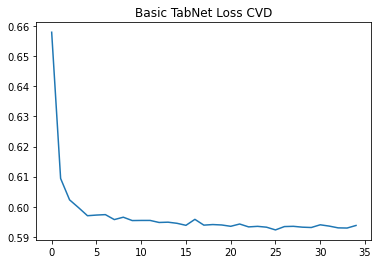

In [39]:
# plot losses
plt.plot(clf.history['loss'])
plt.title('Basic TabNet Loss CVD')
plt.savefig('charts/models/TabNet/basic_loss.png', bbox_inches='tight')

### Global Explainability

In [47]:
feat_weights = clf.feature_importances_

# zip to feature names
input_cols = X_train1.columns.to_list()
feat_dict = dict(zip(input_cols, feat_weights))

In [48]:
import operator
sorted_d = dict( sorted(feat_dict.items(), key=operator.itemgetter(1),reverse=True))

In [49]:
top = dict()
# Iterate over all the items in dictionary and filter items which has even keys
for (key, value) in sorted_d.items():
   # Check if key is even then add pair to new dictionary
   if value >= 0.01:
        top[key] = value
print('Top Contritbuting Features : ')
replaced_list = [x if x not in gv.input_mapping else gv.input_mapping[x] for x in list(top.keys()) ]
print(replaced_list)

Top Contritbuting Features : 
['hypertension', 'age', 'whole body fat-free mass', 'employment status', 'Sex', 'ethnic background']


In [54]:
no_contribution = dict()
# Iterate over all the items in dictionary and filter items which has even keys
for (key, value) in sorted_d.items():
   # Check if key is even then add pair to new dictionary
   if value ==0:
        no_contribution[key] = value
print('Non-contritbuting Features : ')
replaced_list2 = [x if x not in gv.input_mapping else gv.input_mapping[x] for x in list(no_contribution.keys()) ]
print(replaced_list2)

Non-contritbuting Features : 
['dried fruit intake', 'cheese intake', 'oily fish intake', 'major dietary changes in the last 5 years', 'freq depressed mood past 2 weeks', 'coffee type', 'non-oily fish intake', 'processed meat intake', 'HbA1c', 'cereal type', 'doctor anxiety or depression', 'tea intake', 'systolic blood pressure', 'beef intake', 'cooked veg intake', 'LP-a', 'waist circumference', 'raw veg intake', 'variation in diet', 'water intake', 'body fat percentage', 'hip circumference', 'cholesterol', 'non-butter spread', 'past tobacco smoking', 'fresh fruit intake', 'current tobacco smoking', 'bread intake', 'triglyceride', 'poultry intake', 'BMI', 'cereal intake', 'whole body fat mass', 'Qualifications', 'milk type', 'HDL', 'psychologist anxiety or depression', 'spread type', 'APOB']


In [64]:
len(replaced_list2)

39

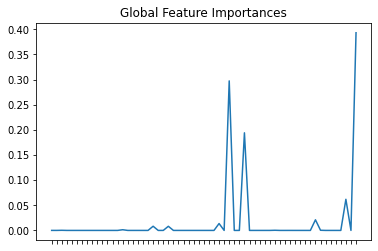

<Figure size 432x288 with 0 Axes>

In [61]:
lists = sorted(feat_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

frame1 = plt.gca()
plt.plot(x, y)
plt.title('Global Feature Importances')
frame1.axes.xaxis.set_ticklabels([])
plt.show()
plt.savefig('charts/models/TabNet/basic_global_features.png', bbox_inches='tight')

### Local Explainablity

In [56]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
test_auc

0.7500657793674272

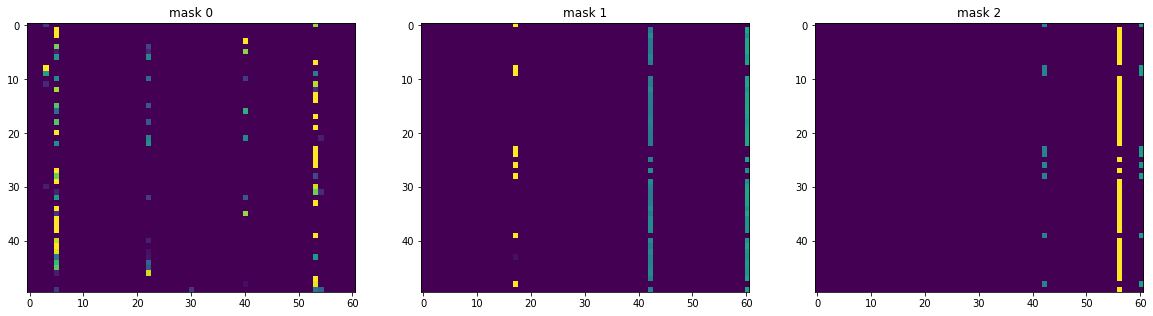

In [63]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

plt.savefig('charts/models/TabNet/basic_masks.png')

## Customize Model Parameters

#### Fit parameters

<ul>
  <li> <b>X_train</b> (np.array): Training Features </li>
  <li> <b>y_train</b> (np.array): Training Targets </li>
  <li> <b>eval_set</b> (list of eval tuple set):  last one used for early stopping </li>
  <li> <b>eval_name</b> (list of str): list of eval set names </li>
  <li> <b>eval_metric</b> (list of str: list of evaluation metrics; last used for early stopping </li>
  <li> <b>max_epochs</b> (int=200): max epochs for training</li>
  <li> <b>patience</b> (int=10):#epochs before early stopping, if 0 then no early stopping performed </li>
  <li> <b>weights</b> (int or dict=0): only for TabNetClassifier, sampling param 0 => no sampling, param 0 => automated sampling with inverse class occurences </li>
  <li> <b>loss_fn</b>(torch.loss): loss fn for training, w classification can set a list of same length as num tasks  </li>
  <li> <b>batch_size</b> (int=1024): #  examples/batch </li>
  <li> <b>virtual_batch_size</b> (int=128): size of mini batches for ghost batch normalization  </li>
  <li> <b>num_workers</b> (int=0): # workers used in torch.utils.data.Dataloader  </li>
  <li> <b>drop_last</b> (bool=False): whether to drop last batch if not complete during training  </li>
  <li> <b>callbacks</b> (list of callback fn): list of custom callbacks </li>
  <li> <b>pretraining_ratio</b> (float): %input features to mask during pretraining  </li>
  <li> <b>warm_start</b> (bool=False): allows to fit twice the same model and start from a warm start  </li>

</ul>

In [ ]:
METRICS = [utilities.recall_m]

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerat

In [ ]:
tabnet_params = {"cat_idxs":cat_idxs, # list of categorical feature indices
                 "cat_dims":cat_dims, # list of categorical features number of modalities (#unique values for a categorical feature)
                 "cat_emb_dim":1, # list of embeddings size for each categorical features
                 "optimizer_fn":torch.optim.Adam, # pytorch optimizer function
                 "optimizer_params":dict(lr=2e-2), # parameters compatible with optimizer_fn
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9}, # dictionary of parameters to apply to the scheduler
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax" # either sparsemax or entmac, masking fn for selecting features
                }


In [ ]:
# build model

In [ ]:
# BCELoss()

### Implement Semi-supervised Pre-training (tbd)

In [ ]:
# import preprocessed data before imputation
df2 = pd.read_csv(gv.tabnet_data)
df2.drop('Unnamed: 0', axis=1, inplace=True)
df2.head()

In [ ]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_val],
    pretraining_ratio=0.8,
)

clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
                      "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax' # This will be overwritten if using pretrain model
)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    from_unsupervised=unsupervised_model
)

### Save & Load TabNet Classifier

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)